In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='813130eb-87c7-499d-8dcb-2d9fdf642789', project_access_token='p-d03fa8a6c37e229bc2b5603e652a2921e741c51f')

pc = project.project_context

## PART 1 - Scrape geo data table, preprocess the data, create map with points superimposed

#### Import the necessary modules

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

#### Use BeautifulSoup to scrape the table we want

In [4]:
wiki_url = 'https://wiki.openstreetmap.org/wiki/List_of_London_Underground_stations'
wiki_page = requests.get(wiki_url).text
wiki_doc = BeautifulSoup(wiki_page, 'lxml')

stations_table = wiki_doc.find('table', {'class': 'wikitable'})

#### Load web table into a dataframe

In [5]:
#only take the columns for name, latitude and logitude
indices = [0,1,2]

#create blank dataframe for the table
stations_df = pd.DataFrame(columns=['Name','Latitude','Longitude'])

#loop through table to load rows into dataframe
for tr in stations_table.find_all('tr')[1:]:
    cells = tr.find_all('td')
    stations_df = stations_df.append({
            'Name': cells[0].text.strip(),
            'Latitude': cells[1].text.strip(),
            'Longitude': cells[2].text.strip()
        }, ignore_index=True)    

#verify dataframe contents, size and datatypes
print(stations_df.head())
print()
print(stations_df.shape)
print(stations_df.dtypes)

            Name     Latitude     Longitude
0     Acton Town    51.502500     -0.278126
1  Acton Central  51.50883531  -0.263033174
2  Acton Central  51.50856013  -0.262879534
3        Aldgate     51.51394      -0.07537
4   Aldgate East     51.51514      -0.07178

(302, 3)
Name         object
Latitude     object
Longitude    object
dtype: object


#### Wrangle data

In [6]:
#some stations appear more than once so only keep one
stations_df.drop_duplicates(subset='Name', keep='first', inplace=True)
print(stations_df.shape)

(291, 3)


In [7]:
#the entry for Canada Water contains text so set it manually
stations_df.loc[stations_df['Name'] == 'Canada Water', ['Latitude']] = '51.49787'
stations_df.loc[stations_df['Name'] == 'Canada Water', ['Longitude']] = '-0.04967'

#map lat and lon datatypes to float
stations_df['Latitude'] = stations_df['Latitude'].astype(float)
stations_df['Longitude'] = stations_df['Longitude'].astype(float)

print(stations_df.loc[stations_df['Name'] == 'Canada Water'])

            Name  Latitude  Longitude
42  Canada Water  51.49787   -0.04967


#### Create map of London and superimpose the stations

In [8]:
#find London's coordinates
from geopy.geocoders import Nominatim
address = 'London, UK'
geolocator = Nominatim(user_agent="London")
location = geolocator.geocode(address)
london_latitude = location.latitude
london_longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(london_latitude, london_longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [9]:
#create map of London
map_london = folium.Map(location=[london_latitude, london_longitude], zoom_start=11)

#overlay the stations from the dataframe onto the map
for lat, lng, name in zip(stations_df['Latitude'], stations_df['Longitude'], stations_df['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        parse_html=False).add_to(map_london)  
    
map_london

## PART 2 - Use Foursquare API to grab data about venues surrounding each station

#### Define Foursquare API credentials

In [10]:
CLIENT_ID = 'WYE3EDU5TPQNAAHK210ZA23SFTNTKI2OKL3TUFCHRD4CBA4L'
CLIENT_SECRET = 'MVFWBJGJLGCTV0NMRH5LCFDY3R4UXPD5XIY15N5JHR3MHYFP'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WYE3EDU5TPQNAAHK210ZA23SFTNTKI2OKL3TUFCHRD4CBA4L
CLIENT_SECRET:MVFWBJGJLGCTV0NMRH5LCFDY3R4UXPD5XIY15N5JHR3MHYFP


#### Define and run query to return the high level categories of venues

In [11]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
results = requests.get(categories_url).json()

In [12]:
#verify number of category types returned
len(results['response']['categories'])

10

#### Create blank list to hold the category types and populate with the response to the request above

In [13]:
categories_list = []

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


#### Create function to execute the explore request for each station and return the total results for each category ID

In [14]:
def get_venues_count(latitude, longitude, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                latitude,
                longitude,
                radius,
                categoryId)

    return requests.get(explore_url).json()['response']['totalResults']

#### Create dataframe to show each station and the count of each venue type, to be populated by the function above

In [15]:
stations_venues_df = stations_df.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0
stations_venues_df

,Name,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Acton Town,51.502500,-0.278126,0,0,0,0,0,0,0,0,0,0
1,Acton Central,51.508835,-0.263033,0,0,0,0,0,0,0,0,0,0
3,Aldgate,51.513940,-0.075370,0,0,0,0,0,0,0,0,0,0
4,Aldgate East,51.515140,-0.071780,0,0,0,0,0,0,0,0,0,0
5,Alperton,51.540970,-0.300610,0,0,0,0,0,0,0,0,0,0
6,Amersham,51.674350,-0.607320,0,0,0,0,0,0,0,0,0,0
7,Angel,51.532530,-0.105790,0,0,0,0,0,0,0,0,0,0
8,Archway,51.565360,-0.134740,0,0,0,0,0,0,0,0,0,0
9,Arnos Grove,51.616250,-0.133550,0,0,0,0,0,0,0,0,0,0
10,Arsenal,51.558470,-0.105610,0,0,0,0,0,0,0,0,0,0


#### Reset index on new dataframe so that the function can identify the correct rows to update

In [16]:
stations_venues_df.reset_index(drop=True, inplace=True)
stations_venues_df

,Name,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Acton Town,51.502500,-0.278126,0,0,0,0,0,0,0,0,0,0
1,Acton Central,51.508835,-0.263033,0,0,0,0,0,0,0,0,0,0
2,Aldgate,51.513940,-0.075370,0,0,0,0,0,0,0,0,0,0
3,Aldgate East,51.515140,-0.071780,0,0,0,0,0,0,0,0,0,0
4,Alperton,51.540970,-0.300610,0,0,0,0,0,0,0,0,0,0
5,Amersham,51.674350,-0.607320,0,0,0,0,0,0,0,0,0,0
6,Angel,51.532530,-0.105790,0,0,0,0,0,0,0,0,0,0
7,Archway,51.565360,-0.134740,0,0,0,0,0,0,0,0,0,0
8,Arnos Grove,51.616250,-0.133550,0,0,0,0,0,0,0,0,0,0
9,Arsenal,51.558470,-0.105610,0,0,0,0,0,0,0,0,0,0


#### Run the function on the table, request the total count of venue of each category for each station

In [119]:
for i, row in stations_venues_df.iterrows():
    #in case the function or the API call fails
    try:
        print(i)
        for c in categories_list:
            stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Latitude.iloc[i], stations_venues_df.Longitude.iloc[i], radius=1000, categoryId=c[1])
    except:
        continue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [143]:
#show the result
stations_venues_df

,Name,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Acton Town,51.502500,-0.278126,3,3,0,32,15,18,50,4,29,12
1,Acton Central,51.508835,-0.263033,4,4,0,25,12,17,29,3,29,9
2,Aldgate,51.513940,-0.075370,40,60,5,224,142,114,135,18,143,124
3,Aldgate East,51.515140,-0.071780,39,60,3,212,139,107,137,20,145,122
4,Alperton,51.540970,-0.300610,2,4,0,11,8,4,10,3,16,3
5,Amersham,51.674350,-0.607320,1,3,0,15,4,5,10,3,20,4
6,Angel,51.532530,-0.105790,31,58,1,156,86,60,75,13,94,40
7,Archway,51.565360,-0.134740,4,8,0,42,25,15,35,7,34,24
8,Arnos Grove,51.616250,-0.133550,0,2,0,7,4,7,7,0,20,4
9,Arsenal,51.558470,-0.105610,7,13,0,100,36,25,38,4,65,41


#### Save the resulting dataframe as a CSV in the project space so we don't have to run the function again

In [163]:
project.save_data(data=stations_venues_df.to_csv(index=False),file_name='stations_venues_df.csv',overwrite=True)

{'file_name': 'stations_venues_df.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'courseracaptstone-donotdelete-pr-jofaciwixlf9ss',
 'asset_id': '762fa4e8-18fc-414b-863b-cc6b69e9a6c0'}

## PART 3 - Explore and cluster the data

#### Load the saved csv and convert to a dataframe

In [17]:
my_file = project.get_file("stations_venues_df.csv")
stations_venues_df = pd.read_csv(my_file)

#### Drop venue types 'Event', 'Outdoors & Recreation', and 'Travel & Transport' as we are only interested in the others

In [19]:
stations_venues_df.drop(['Event', 'Outdoors & Recreation', 'Travel & Transport'], axis=1, inplace=True)
stations_venues_df

,Name,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Residence,Shop & Service
0,Acton Town,51.502500,-0.278126,3,3,32,15,50,4,29
1,Acton Central,51.508835,-0.263033,4,4,25,12,29,3,29
2,Aldgate,51.513940,-0.075370,40,60,224,142,135,18,143
3,Aldgate East,51.515140,-0.071780,39,60,212,139,137,20,145
4,Alperton,51.540970,-0.300610,2,4,11,8,10,3,16
5,Amersham,51.674350,-0.607320,1,3,15,4,10,3,20
6,Angel,51.532530,-0.105790,31,58,156,86,75,13,94
7,Archway,51.565360,-0.134740,4,8,42,25,35,7,34
8,Arnos Grove,51.616250,-0.133550,0,2,7,4,7,0,20
9,Arsenal,51.558470,-0.105610,7,13,100,36,38,4,65


#### Import the modules we need

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#### Explore the absolute count of each venue type across all stations

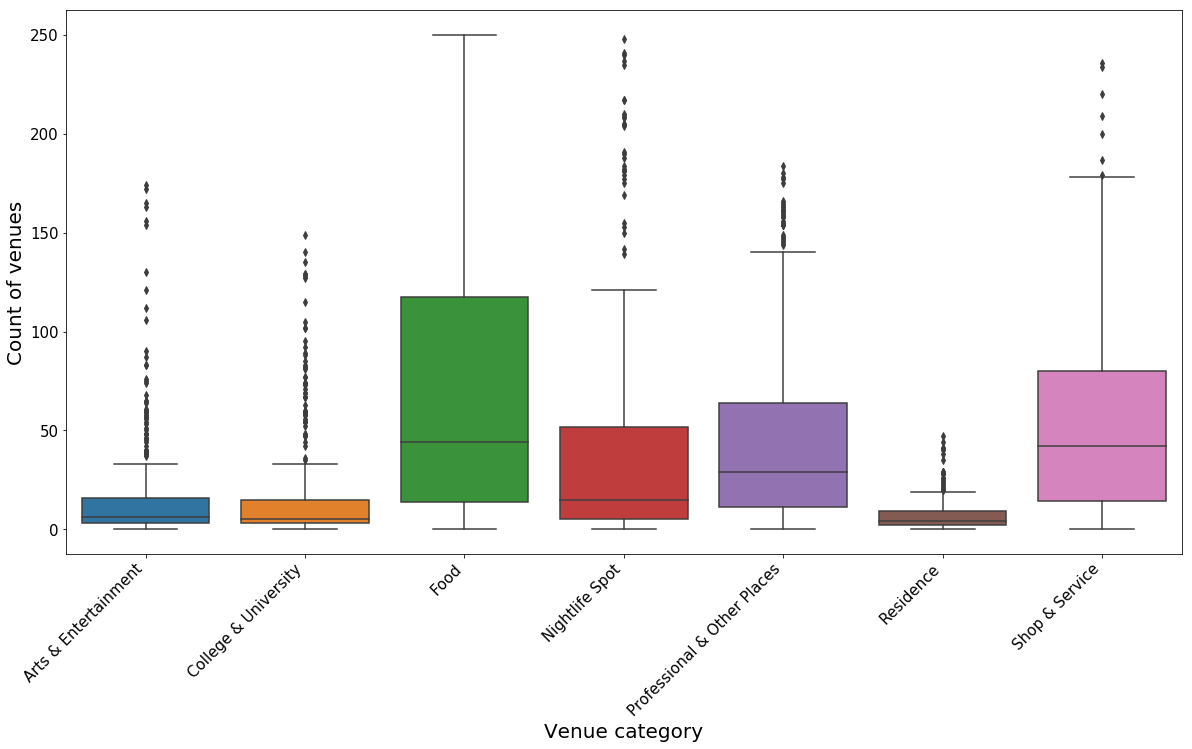

In [22]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot
ax = sns.boxplot(data=stations_venues_df[['Arts & Entertainment', 'College & University', 'Food', 'Nightlife Spot', 'Professional & Other Places', 'Residence', 'Shop & Service']])
ax.set_ylabel('Count of venues', fontsize=20)
ax.set_xlabel('Venue category', fontsize=20)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')

plt.show()

#### Convert dataframe to an array and run it through the MinMaxScaler

In [23]:
X = stations_venues_df.values[:,3:]
X

array([[3, 3, 32, ..., 50, 4, 29],
       [4, 4, 25, ..., 29, 3, 29],
       [40, 60, 224, ..., 135, 18, 143],
       ...,
       [5, 2, 46, ..., 34, 5, 78],
       [1, 1, 15, ..., 8, 3, 6],
       [6, 2, 28, ..., 21, 7, 34]], dtype=object)

In [24]:
from sklearn.preprocessing import MinMaxScaler

cluster_dataset = MinMaxScaler().fit_transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


#### Convert the array back to a dataframe with the appropriate column headings

In [25]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = ['Arts & Entertainment', 'College & University', 'Food', 'Nightlife Spot', 'Professional & Other Places', 'Residence', 'Shop & Service']
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Residence,Shop & Service
0,0.017241,0.020134,0.128,0.060484,0.271739,0.085106,0.122881
1,0.022989,0.026846,0.100,0.048387,0.157609,0.063830,0.122881
2,0.229885,0.402685,0.896,0.572581,0.733696,0.382979,0.605932
3,0.224138,0.402685,0.848,0.560484,0.744565,0.425532,0.614407
4,0.011494,0.026846,0.044,0.032258,0.054348,0.063830,0.067797


#### Explore the relative count of each venue type across all stations

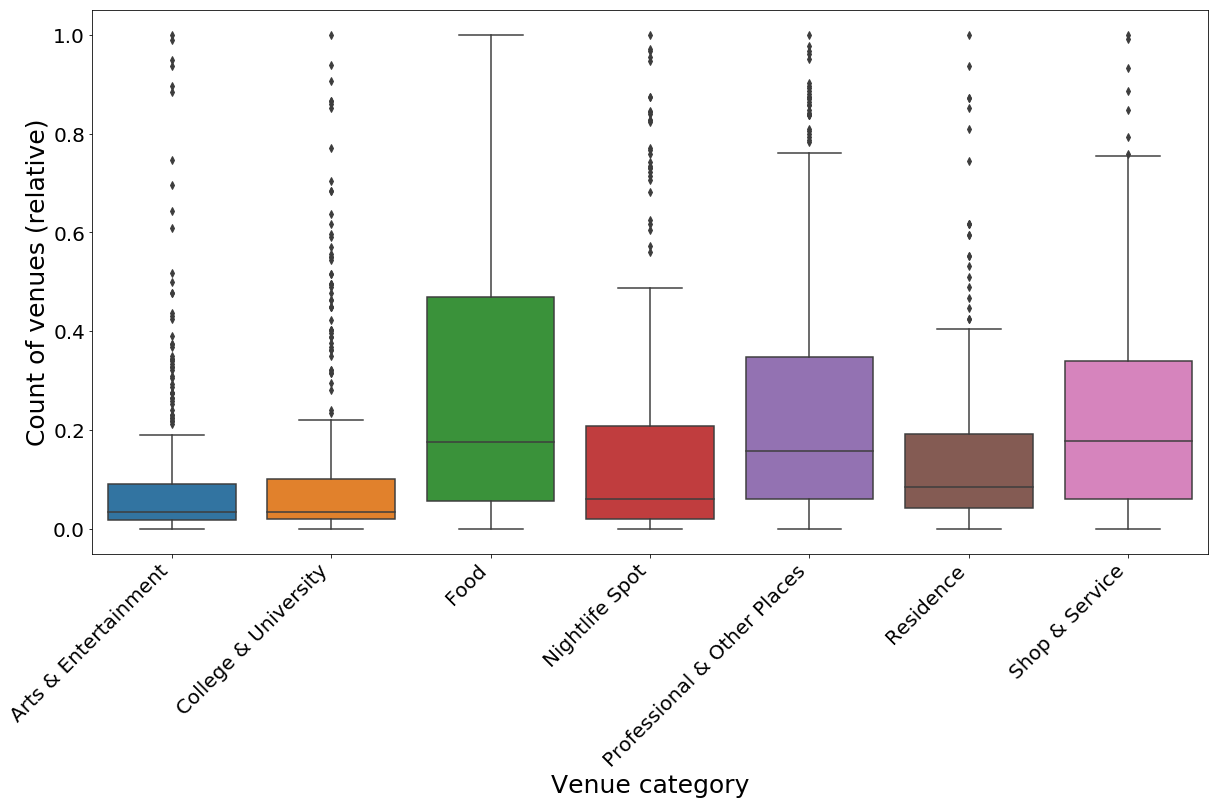

In [26]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

#### Run a KMeans analysis on the dataframe

In [27]:
# number of clusters
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_

#create dataframe with absolute venue counts and cluster numbers
stations_clusters_df = stations_venues_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels

#create dataframe with relative venue counts and cluster numbers
stations_clusters_scaled_df = cluster_df.copy()
stations_clusters_scaled_df['Cluster'] = kmeans_labels
stations_clusters_scaled_df['Name'] = stations_venues_df['Name']
stations_clusters_scaled_df['Latitude'] = stations_venues_df['Latitude']
stations_clusters_scaled_df['Longitude'] = stations_venues_df['Longitude']

In [28]:
stations_clusters_df

,Name,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Residence,Shop & Service,Cluster
0,Acton Town,51.502500,-0.278126,3,3,32,15,50,4,29,0
1,Acton Central,51.508835,-0.263033,4,4,25,12,29,3,29,0
2,Aldgate,51.513940,-0.075370,40,60,224,142,135,18,143,1
3,Aldgate East,51.515140,-0.071780,39,60,212,139,137,20,145,1
4,Alperton,51.540970,-0.300610,2,4,11,8,10,3,16,0
5,Amersham,51.674350,-0.607320,1,3,15,4,10,3,20,0
6,Angel,51.532530,-0.105790,31,58,156,86,75,13,94,2
7,Archway,51.565360,-0.134740,4,8,42,25,35,7,34,0
8,Arnos Grove,51.616250,-0.133550,0,2,7,4,7,0,20,0
9,Arsenal,51.558470,-0.105610,7,13,100,36,38,4,65,3


In [29]:
stations_clusters_scaled_df

,Arts & Entertainment,College & University,Food,Nightlife Spot,Professional & Other Places,Residence,Shop & Service,Cluster,Name,Latitude,Longitude
0,0.017241,0.020134,0.128,0.060484,0.271739,0.085106,0.122881,0,Acton Town,51.502500,-0.278126
1,0.022989,0.026846,0.100,0.048387,0.157609,0.063830,0.122881,0,Acton Central,51.508835,-0.263033
2,0.229885,0.402685,0.896,0.572581,0.733696,0.382979,0.605932,1,Aldgate,51.513940,-0.075370
3,0.224138,0.402685,0.848,0.560484,0.744565,0.425532,0.614407,1,Aldgate East,51.515140,-0.071780
4,0.011494,0.026846,0.044,0.032258,0.054348,0.063830,0.067797,0,Alperton,51.540970,-0.300610
5,0.005747,0.020134,0.060,0.016129,0.054348,0.063830,0.084746,0,Amersham,51.674350,-0.607320
6,0.178161,0.389262,0.624,0.346774,0.407609,0.276596,0.398305,2,Angel,51.532530,-0.105790
7,0.022989,0.053691,0.168,0.100806,0.190217,0.148936,0.144068,0,Archway,51.565360,-0.134740
8,0.000000,0.013423,0.028,0.016129,0.038043,0.000000,0.084746,0,Arnos Grove,51.616250,-0.133550
9,0.040230,0.087248,0.400,0.145161,0.206522,0.085106,0.275424,3,Arsenal,51.558470,-0.105610


#### Explore the different clusters to see differences

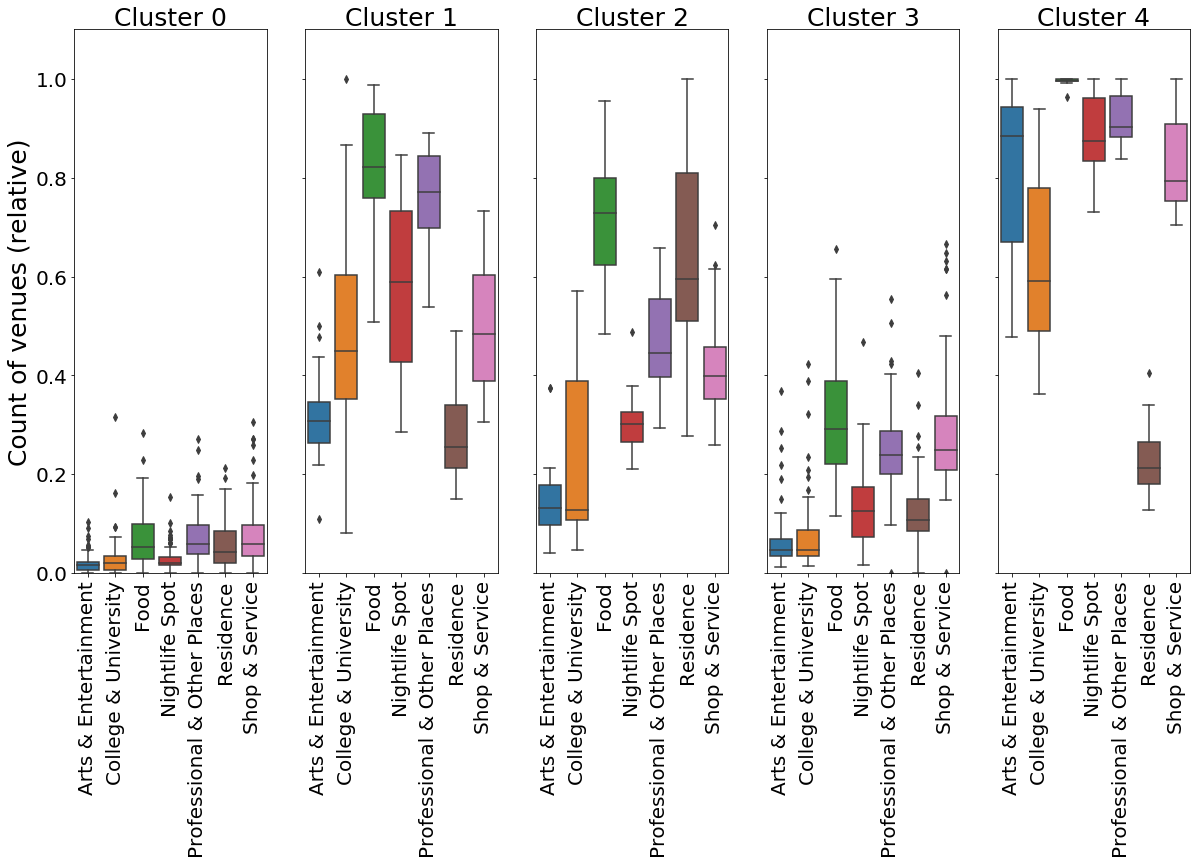

In [30]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)

for k in range(kclusters):
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_scaled_df[stations_clusters_scaled_df['Cluster'] == k].drop(['Cluster', 'Latitude', 'Longitude'],1), ax=axes[k])

plt.show()

## PART 4 - Redraw map with stations colour-coded by cluster

In [34]:
from geopy.geocoders import Nominatim

address = 'London, UK'

geolocator = Nominatim(user_agent="London")
location = geolocator.geocode(address)
london_latitude = location.latitude
london_longitude = location.longitude

In [35]:
map_london_underground = folium.Map(location=[london_latitude, london_longitude], zoom_start=11)

for lat, lng, name, cluster in zip(stations_clusters_df['Latitude'], stations_clusters_df['Longitude'], stations_clusters_df['Name'], stations_clusters_df['Cluster']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    colors=['blue','green','orange','red', 'white']
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.6,
        parse_html=False).add_to(map_london_underground)  
    
map_london_underground